In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Reading the data from the csv file
import pandas as pd
customer_data = pd.read_csv('data.csv')

# Converting the data into an array
customer_data = np.array(customer_data)

# removing the first column as it is not required
customer_data = customer_data[:,1:]
print(customer_data.shape)
# standardizing the data
mean = np.mean(customer_data,axis=0)
std = np.std(customer_data,axis=0)
customer_data = (customer_data-mean)/std

(2000, 7)


##### GMM CLASS

In [5]:
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self,iterations = 100):
        self.X = None
        self.n_components = None
        self.iterations = iterations
        self.mu = None
        self.pi = None
        self.cov = None
        self.log_likelihoods = []
        self.responsibilities = None
    
    def fit(self,X,n_components):
        self.X = X
        self.n_components = n_components
        self.mu = np.random.normal(size=(self.n_components,self.X.shape[1]))
        self.pi = np.ones(self.n_components)/self.n_components
        self.cov = np.array([np.eye(self.X.shape[1])] * self.n_components)
        for _ in range(self.iterations):
            responsibilities = self.expectation()
            self.responsibilities = responsibilities
            self.maximization(responsibilities)
            self.log_likelihoods.append(self.log_likelihood())
            if(len(self.log_likelihoods)>2):
                if(np.abs(self.log_likelihoods[-1]-self.log_likelihoods[-2])<0.0001):
                    break

        
    def expectation(self):
        gamma = np.zeros((self.X.shape[0],self.n_components))
        for k in range(self.n_components):
            gamma[:,k] = self.pi[k]*self.gaussian(self.mu[k],self.cov[k])
        gamma = gamma/np.sum(gamma, axis=1, keepdims=True)
        return gamma
    
    def maximization(self,gamma):
        N_k = np.sum(gamma,axis=0)
        self.mu = np.dot(gamma.T,self.X)/N_k[:,None]
        self.pi = N_k/np.sum(N_k)
        for k in range(self.n_components):
            diff = self.X - self.mu[k]
            # Regularization is added to avoid singular matrix
            self.cov[k] = np.dot(gamma[:,k]*diff.T,diff)/N_k[k] + 1e-6 * np.eye(self.X.shape[1])

    def gaussian(self,mu,cov):
        # diff = X - mu
        # N = X.shape[1]
        # cov_inverse = np.linalg.inv(cov)
        # numerator = np.exp(-0.5 * np.sum(np.dot((diff@ cov_inverse), diff.T), axis=1))
        # denominator = np.sqrt((2*np.pi)**N*np.linalg.det(cov))
        # return numerator/denominator
        rv = multivariate_normal(mean=mu, cov=cov)
        return rv.pdf(self.X)
    
    def log_likelihood(self):
        likelihood = np.zeros((self.X.shape[0],self.n_components))
        for k in range(self.n_components):
            likelihood[:,k] = self.pi[k]*self.gaussian(self.mu[k],self.cov[k])
        return np.sum(np.log(np.sum(likelihood,axis=1)))
        

In [6]:
g = GMM()
g.fit(customer_data,4)
print(g.log_likelihoods)
# Assign cluster labels
cluster_labels = np.argmax(g.responsibilities, axis=1)

[-16206.622547721214, -15469.601265405092, -10286.473758722288, -5736.585995171, -4429.871275348081, -3173.975157170192, -2176.9987546674693, -2147.7729649210346, -2147.3120752375653, -2146.9765897046236, -2146.627649650377, -2146.2164831802634, -2145.7003241175958, -2145.0151343708053, -2144.046865334567, -2142.5708269897013, -2140.092731580729, -2135.3574950136367, -2124.479596333489, -2091.498371301458, -1944.2920080283243, -1122.7781188297067, 3067.0136714063847, 3079.511602571404, 3079.8490001685886, 3079.8660437965136, 3079.8676687418515, 3079.86785543687, 3079.8678788590487]


##### CLUSTERING WINE-DATASET

In [7]:
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans

wine = load_wine()
wine_data = wine.data
wine_labels = wine.target

# standardizing the data
mean = np.mean(wine_data,axis=0)
std = np.std(wine_data,axis=0)
wine_data = (wine_data-mean)/std

# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
wine_pca = pca.fit_transform(wine_data)

# clustering using GMM
w = GMM()
w.fit(wine_pca,3)

# Assign cluster labels
wine_cluster_labels_gmm = np.argmax(w.responsibilities, axis=1)

# clustering using KMeans
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(wine_pca)
wine_cluster_labels_kmeans = kmeans.labels_

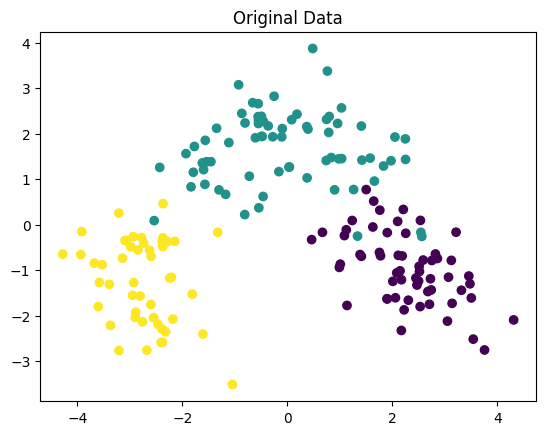

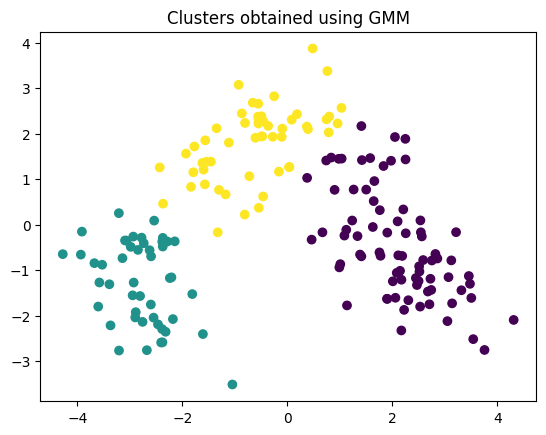

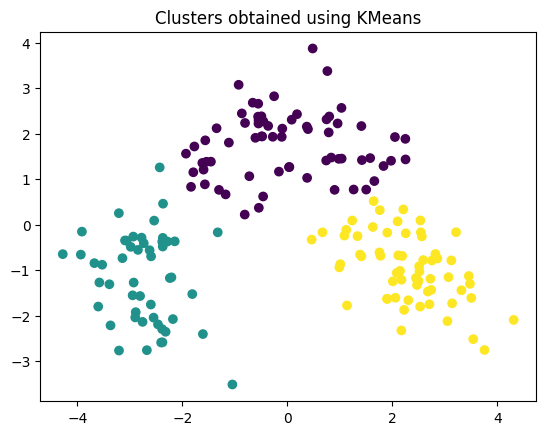

In [8]:
# Plotting the original target clusters
plt.scatter(wine_pca[:,0],wine_pca[:,1],c=wine_labels)
plt.title("Original Data")
plt.show()

# Plotting the clusters obtained using GMM
plt.scatter(wine_pca[:,0],wine_pca[:,1],c=wine_cluster_labels_gmm)
plt.title("Clusters obtained using GMM")
plt.show()

# Plotting the clusters obtained using KMeans
plt.scatter(wine_pca[:,0],wine_pca[:,1],c=wine_cluster_labels_kmeans)
plt.title("Clusters obtained using KMeans")
plt.show()

##### AIC and BIC

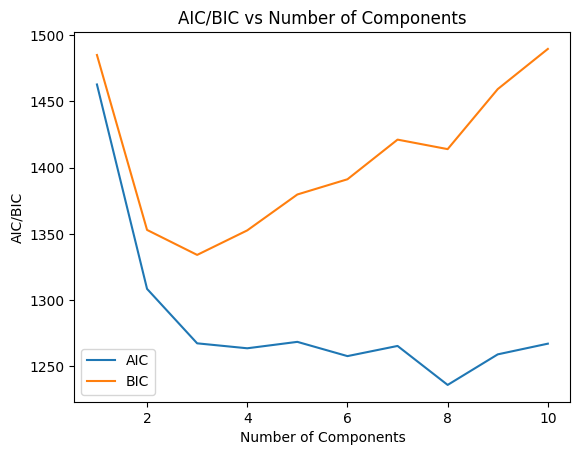

In [9]:
x = [1,2,3,4,5,6,7,8,9,10]
aic= []
bic = []
d = wine_pca.shape[1]
for i in x:
    w_ = GMM()
    w_.fit(wine_pca,i)
    p = i*d*d + i*d + i
    aic.append(2*p-2*w_.log_likelihoods[-1])
    bic.append(p*np.log(wine_pca.shape[0])-2*w_.log_likelihoods[-1])
plt.plot(x,aic)
plt.plot(x,bic)
plt.xlabel('Number of Components')
plt.ylabel('AIC/BIC')
plt.title('AIC/BIC vs Number of Components')
plt.legend(['AIC','BIC'])
plt.show()

In [10]:
# minimum n_components from AIC
n1 = np.argmin(aic)+1
# minimum n_components from BIC
n2 = np.argmin(bic)+1
print(n1,n2)

8 3


##### OPTIMAL CLUSTERS (AIC)

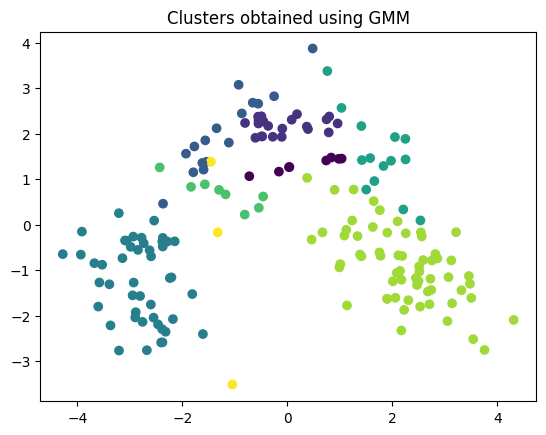

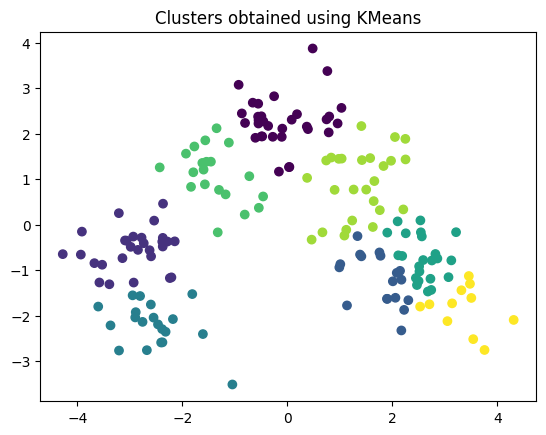

In [11]:
w = GMM()
w.fit(wine_pca,n1)
wine_cluster_labels_gmm = np.argmax(w.responsibilities, axis=1)
kmeans = KMeans(n_clusters=n1, random_state=0, n_init="auto").fit(wine_pca)
wine_cluster_labels_kmeans = kmeans.labels_

# Plotting the clusters obtained using GMM
plt.scatter(wine_pca[:,0],wine_pca[:,1],c=wine_cluster_labels_gmm)
plt.title("Clusters obtained using GMM")
plt.show()

# Plotting the clusters obtained using KMeans
plt.scatter(wine_pca[:,0],wine_pca[:,1],c=wine_cluster_labels_kmeans)
plt.title("Clusters obtained using KMeans")
plt.show()

##### OPTIMAL CLUSTERS (BIC)

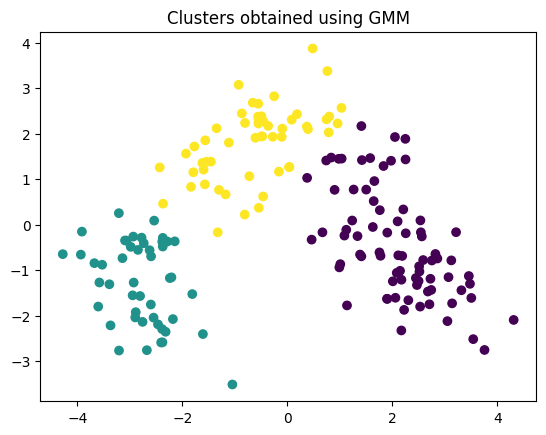

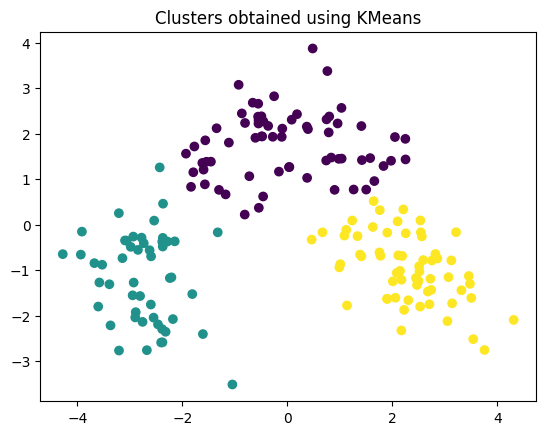

In [12]:
w = GMM()
w.fit(wine_pca,n2)
wine_cluster_labels_gmm = np.argmax(w.responsibilities, axis=1)
kmeans = KMeans(n_clusters=n2, random_state=0, n_init="auto").fit(wine_pca)
wine_cluster_labels_kmeans = kmeans.labels_

# Plotting the clusters obtained using GMM
plt.scatter(wine_pca[:,0],wine_pca[:,1],c=wine_cluster_labels_gmm)
plt.title("Clusters obtained using GMM")
plt.show()

# Plotting the clusters obtained using KMeans
plt.scatter(wine_pca[:,0],wine_pca[:,1],c=wine_cluster_labels_kmeans)
plt.title("Clusters obtained using KMeans")
plt.show()

##### SILHOUTTE SCORES

In [13]:
from sklearn.metrics import silhouette_score
w = GMM()
w.fit(wine_pca,n1)
wine_cluster_labels_gmm = np.argmax(w.responsibilities, axis=1)
kmeans = KMeans(n_clusters=n1, random_state=0, n_init="auto").fit(wine_pca)
wine_cluster_labels_kmeans = kmeans.labels_
# GMM for n_components for optimal for AIC
silhouette_avg = silhouette_score(wine_pca, wine_cluster_labels_gmm)
print("silhoutte score for optimal AIC using GMMs: ",silhouette_avg)
# K-means for n_components for optimal for AIC
silhouette_avg = silhouette_score(wine_pca, wine_cluster_labels_kmeans)
print("silhoutte score for optimal AIC using Kmeans: ",silhouette_avg)
w = GMM()
w.fit(wine_pca,n2)
wine_cluster_labels_gmm = np.argmax(w.responsibilities, axis=1)
kmeans = KMeans(n_clusters=n2, random_state=0, n_init="auto").fit(wine_pca)
wine_cluster_labels_kmeans = kmeans.labels_
# GMM for n_components for optimal for BIC
silhouette_avg = silhouette_score(wine_pca, wine_cluster_labels_gmm)
print("silhoutte score for optimal BIC using GMMs: ",silhouette_avg)
# K-means for n_components for optimal for BIC
silhouette_avg = silhouette_score(wine_pca, wine_cluster_labels_kmeans)
print("silhoutte score for optimal BIC using Kmeans: ",silhouette_avg)

from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=n1, random_state=0)
gmm.fit(wine_pca)
labels = gmm.predict(wine_pca)
silhouette_avg = silhouette_score(wine_pca, labels)
print("silhoutte score for optimal AIC using GMMs-inbuilt: ",silhouette_avg)
gmm = GaussianMixture(n_components=n2, random_state=0)
gmm.fit(wine_pca)
labels = gmm.predict(wine_pca)
silhouette_avg = silhouette_score(wine_pca, labels)
print("silhoutte score for optimal BIC using GMMs-inbuilt: ",silhouette_avg)

silhoutte score for optimal AIC using GMMs:  0.18979340037648026
silhoutte score for optimal AIC using Kmeans:  0.38264010632733464
silhoutte score for optimal BIC using GMMs:  0.5581473461293222
silhoutte score for optimal BIC using Kmeans:  0.5601697480957203
silhoutte score for optimal AIC using GMMs-inbuilt:  0.3616068651162134
silhoutte score for optimal BIC using GMMs-inbuilt:  0.5591116207103002


#### OBSERVATIONS
1. The clusters are variable in size and shape in GMM whereas in KMeans the clusters are spherical and of equal size.
2. The Silhoutte score of Kmeans is higher than that of GMM.
3. BIC is giving the optimal number of clusters and high Silhoutte score for GMM.
4. The clusters in GMM do not have well-defined boundaries, whereas in KMeans, the boundaries between clusters are clear and distinct.